# Creating crosslinked polymers with SwiftPol.crosslink

This code uses SwiftPol's framework to build a chain of Polyethylene Glycol Diacrylate (PEGDA) and build a large crosslinked polymer network.


<img src="../Repo/crosslinking_flow.png" alt="Image Description" width="1000">

In [3]:
# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
import random
# Import SwiftPol
from swiftpol import build, crosslink

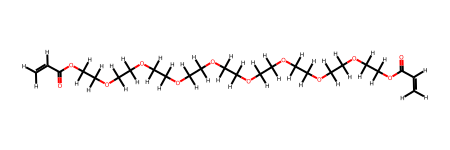

In [4]:
# Build linear PEGDA chain using SwiftPol
monomer = ["IC=CC(=O)OI", "IOCCOI"] # PEGDA monomers with iodinated polymerization points
reaction = AllChem.ReactionFromSmarts('[C:1]-[O:2]-[I:3].[C:4]-[O:5]-[I:6]>>[C:1]-[O:2]-[C:4].[I:3]-[I:6].[O:5]')
sequence = 'ABBBBBBBBBA' # SwiftPol can easily build irregular sequence motifs
polymer = build.build_polymer(sequence = sequence,
                                monomer_list = monomer,
                                reaction = reaction,
                                terminal = 'hydrogen',
                                chainID='A')
polymer

### Defining polymerization
For PEGDA, either a linear or branched addition is possible.

The addition of a 2nd PEGDA chain occurs across the acrylate C=C double bond.

We can use halogens to guide SwiftPol to the correct reaction sites.


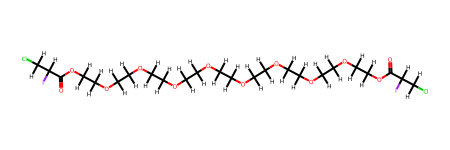

In [5]:
# Activation
activation_reaction=AllChem.ReactionFromSmarts('[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]')
activatorCl = Chem.MolFromSmiles('Cl')
activatorI = Chem.MolFromSmiles('I')

# Apply activation reaction twice (once for each acrylate)
starting_polymer = activation_reaction.RunReactants([polymer, activatorCl, activatorI])[0][0]
Chem.SanitizeMol(starting_polymer)
starting_polymer = activation_reaction.RunReactants([starting_polymer, activatorCl, activatorI])[0][0]
Chem.SanitizeMol(starting_polymer)

Chem.AddHs(starting_polymer)

Design some reaction templates for linear and branched addition

For support with constructing reaction SMARTS, raise an issue at https://github.com/matta-research-group/SwiftPol/issues

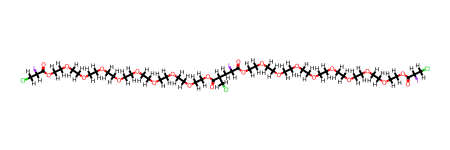

In [6]:
# Linear addition
reaction_templates = {'linear' : ['[C:1][I:2].[C:3][Cl:4]>>[C:1][C:3].[I:2].[Cl:4]']}
linear_addition = AllChem.ReactionFromSmarts(reaction_templates['linear'][0])
# React 2 PEGDA chains together using the reaction template we have written for linear addition
linear_polymer = linear_addition.RunReactants([starting_polymer, starting_polymer])[0][0]
linear_polymer

For branched addition, we can pick a random acrylate group within the chain to add a branch.

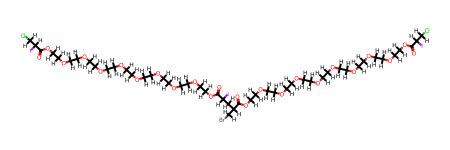

In [7]:
# Branched addition
activation_reaction=AllChem.ReactionFromSmarts('[O:1][C:2][C:3](-[C:4][Cl:5])[C:6][C:7][C:8].[Br:9]>>[O:1][C:2][C:3](-[C:4][Br:9])[C:6][C:7][C:8].[Cl:5]')
activatorBr = Chem.MolFromSmiles('Br')
activated_for_branching = activation_reaction.RunReactants([linear_polymer, activatorBr])[0][0]

Chem.SanitizeMol(activated_for_branching)
activated_for_branching

and then use another reaction template to add a 3rd PEGDA chain at the branched point

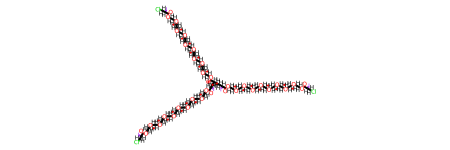

In [8]:
reaction_templates = {'branched' : ['[C:1][Br:2].[C:3][Cl:4]>>[C:1][C:3].[Br:2].[Cl:4]']}
branched_addition = AllChem.ReactionFromSmarts(reaction_templates['branched'][0])
branched_polymer = branched_addition.RunReactants([activated_for_branching, starting_polymer])[0][0]
Chem.SanitizeMol(branched_polymer)
branched_polymer

To create crosslinks, find close unreacted halogens (in this case, chlorine) and form bonds

Currently, at least one halogen used in the initial polymer activation must be chlorine, for SwiftPol to be able to complete the crosslinking process.

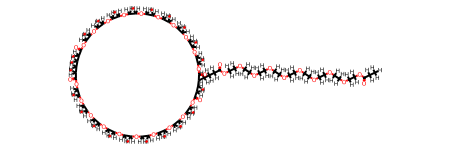

In [9]:
network = crosslink.crosslink_polymer(branched_polymer, percentage_to_crosslink=100)
network

### Bringing it all together

In [10]:
# The reactions for activation and reaction that we just defined
reaction_templates = {'linear_activate' : ['[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]', 'Cl', 'I'],
                      'linear_react' : ['[C:1][I:2].[C:3][Cl:4]>>[C:1][C:3].[I:2].[Cl:4]'],
                      'branched_activate' : ['[O:1][C:2][C:3](-[C:4][Cl:5])[C:6][C:7][C:8].[Br:9]>>[O:1][C:2][C:3](-[C:4][Br:9])[C:6][C:7][C:8].[Cl:5]', 'Br'],
                      'branched_react' : ['[C:1][Br:2].[C:3][Cl:4]>>[C:1][C:3].[Br:2].[Cl:4]']}

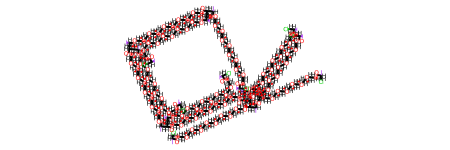

In [11]:
# Build a branched system based on number of iterations/chains added
branched_iter = crosslink.build_branched_polymer(starting_polymer = polymer,
                                            reaction_templates = reaction_templates,
                                            num_iterations=10, 
                                            probability_of_branched_addition=0.5, 
                                            probability_of_linear_addition=0.5)
branched_iter

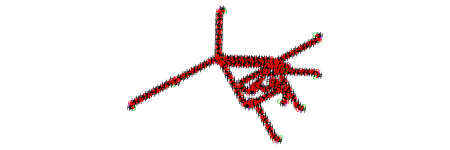

In [12]:
# Alternatively...
# Build up a larger branched system to a target molecular weight
branched_mw = crosslink.build_branched_polymer(starting_polymer = polymer,
                                               reaction_templates = reaction_templates,
                                               target_mw=10000, 
                                               probability_of_branched_addition=0.8, 
                                               probability_of_linear_addition=0.2)
branched_mw

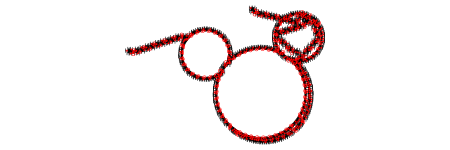

In [13]:
# Crosslink chains and clean up halogens
crosslinked_network = crosslink.crosslink_polymer(branched_mw, percentage_to_crosslink=80)
crosslinked_network

Degree of Crosslinking: 0.64


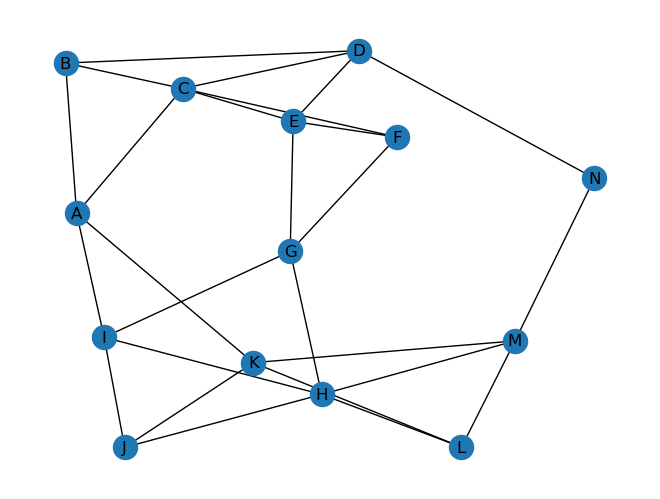

In [14]:
# Use networkX to measure degree of crosslinking (requires NetworkX, matplotlib)
import networkx as nx
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import networkx as nx
# Generate an RDKit graph from the molecule
network_graph = nx.Graph()

# Extract chain IDs for each atom
chain_ids = {}
for atom in crosslinked_network.GetAtoms():
    monomer_info = atom.GetMonomerInfo()
    if monomer_info is not None:
        chain_id = monomer_info.GetChainId()
        chain_ids[atom.GetIdx()] = chain_id

# Add nodes (unique chain IDs)
unique_chain_ids = set(chain_ids.values())
network_graph.add_nodes_from(unique_chain_ids)

# Add edges (bonds between different chain IDs)
for bond in crosslinked_network.GetBonds():
    atom1 = bond.GetBeginAtomIdx()
    atom2 = bond.GetEndAtomIdx()
    chain1 = chain_ids.get(atom1)
    chain2 = chain_ids.get(atom2)

    # Add an edge if the bond connects different chain IDs
    if chain1 and chain2 and chain1 != chain2:
        network_graph.add_edge(chain1, chain2)

# Draw the graph without bond labels
pos = nx.spring_layout(network_graph)
nx.draw(network_graph, pos, with_labels=True)

# Calculate the degree of each node
degrees = dict(network_graph.degree())

# Identify crosslinked nodes (degree > 2)
crosslinked_nodes = [node for node, degree in degrees.items() if degree > 3]

# Calculate the degree of crosslinking
total_nodes = len(network_graph.nodes)
degree_of_crosslinking = len(crosslinked_nodes) / total_nodes

print(f"Degree of Crosslinking: {degree_of_crosslinking:.2f}")